# Data Analysis 3: Assignment 1

#### Subject: Data Analysis 3
#### Author: Marcell Magda

## Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

## 1. Data Preparation

### 1.1 Importing data

In [2]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/MarcellM01/Data-Analysis-3/main/Homework_1/morg-2014-emp.csv'

emp_data = pd.read_csv(file_path)

In [3]:
emp_data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [4]:
emp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149316 entries, 0 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  149316 non-null  int64  
 1   hhid        149316 non-null  int64  
 2   intmonth    149316 non-null  object 
 3   stfips      149316 non-null  object 
 4   weight      149316 non-null  float64
 5   earnwke     149316 non-null  float64
 6   uhours      149316 non-null  int64  
 7   grade92     149316 non-null  int64  
 8   race        149316 non-null  int64  
 9   ethnic      20071 non-null   float64
 10  age         149316 non-null  int64  
 11  sex         149316 non-null  int64  
 12  marital     149316 non-null  int64  
 13  ownchild    149316 non-null  int64  
 14  chldpres    149316 non-null  int64  
 15  prcitshp    149316 non-null  object 
 16  state       149316 non-null  object 
 17  ind02       149316 non-null  object 
 18  occ2012     149316 non-null  int64  
 19  cl

### 1.2 Cleaning the data

In [5]:
# Checking for missing values and getting an overview of the dataset
missing_values_overview = emp_data.isnull().sum()

# Printing out
missing_values_overview

Unnamed: 0         0
hhid               0
intmonth           0
stfips             0
weight             0
earnwke            0
uhours             0
grade92            0
race               0
ethnic        129245
age                0
sex                0
marital            0
ownchild           0
chldpres           0
prcitshp           0
state              0
ind02              0
occ2012            0
class              0
unionmme           0
unioncov       17096
lfsr94             0
dtype: int64

In [6]:
# Cleaning the data by removing rows with missing or infinite values
emp_data = emp_data.replace(np.nan).dropna()

# Check if there are any Null values left
print('Number of null values:', emp_data.isnull().sum())

Number of null values: Unnamed: 0    0
hhid          0
intmonth      0
stfips        0
weight        0
earnwke       0
uhours        0
grade92       0
race          0
ethnic        0
age           0
sex           0
marital       0
ownchild      0
chldpres      0
prcitshp      0
state         0
ind02         0
occ2012       0
class         0
unionmme      0
unioncov      0
lfsr94        0
dtype: int64


### 1.3 Filtering for selected occupations

In [7]:
business_operations_specialists_codes = [
    "0500", "0510", "0520", "0530", "0540", "0565", "0600", "0630", "0640", 
    "0650", "0700", "0710", "0725", "0726", "0735", "0740"
]

# Convert codes to the format used in the dataset
business_operations_specialists_codes_formatted = [int(code) for code in business_operations_specialists_codes]

# Filter the dataset to include only rows where the occupation code is one of the business operations specialists
data_filtered_business = emp_data[emp_data['occ2012'].isin(business_operations_specialists_codes_formatted)]

# Check the shape of the filtered data
data_filtered_business.shape

(3921, 23)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Creating Target Variable

In [8]:
# Creating variable earnings_per_hour in a new column
data_filtered_business['earnings_per_hour'] = data_filtered_business['earnwke'] / data_filtered_business['uhours']

### 2.2 Creating Dummy Variables

In [9]:
# Generate variables for 'df'
data_filtered_business['female'] = (data_filtered_business['sex'] == 2).astype(int)

# Drop extreme values that are below 1 (hourly wages less than 1 USD per hour may be an error)
data_filtered_business = data_filtered_business[data_filtered_business['earnings_per_hour'] >= 1]

# Log of hourly wages
data_filtered_business['ln_earnings_per_hour'] = np.log(data_filtered_business['earnings_per_hour'])

# Union membership
data_filtered_business['union_member'] = (data_filtered_business['unionmme'] == 'Yes').astype(int)

# Different levels of education stored based on their codes

data_filtered_business['BA_degree'] = (data_filtered_business['grade92'] == 43).astype(int)
data_filtered_business['MA_degree'] = (data_filtered_business['grade92'] == 44).astype(int)
data_filtered_business['Prof_degree'] = (data_filtered_business['grade92'] == 45).astype(int)
data_filtered_business['PhD_degree'] = (data_filtered_business['grade92'] == 46).astype(int)

# Employment Categories

data_filtered_business['Employed-At_Work'] = (data_filtered_business['lfsr94'] == "Employed-At Work").astype(int)
data_filtered_business['Employed-Absent'] = (data_filtered_business['lfsr94'] == "Employed-Absent").astype(int)

# Class of Employer

data_filtered_business['Private_For_Profit'] = (data_filtered_business['class'] == "Private, For Profit").astype(int)
data_filtered_business['Government_Federal'] = (data_filtered_business['class'] == "Government - Federal").astype(int)
data_filtered_business['Government_State'] = (data_filtered_business['class'] == "Government - State").astype(int)
data_filtered_business['Government_Local'] = (data_filtered_business['class'] == "Government - Local").astype(int)
data_filtered_business['Private_Nonprofit'] = (data_filtered_business['class'] == "Private, Nonprofit").astype(int)

# Type of Citizenship

data_filtered_business['Native_Born_In_US'] = (data_filtered_business['prcitshp'] == "Native, Born In US").astype(int)
data_filtered_business['Foreign_Born_Not_US_Citizen'] = (data_filtered_business['prcitshp'] == "Foreign Born, Not a US Citizen").astype(int)
data_filtered_business['Foreign_Born_US_Citizen_By_Naturalization'] = (data_filtered_business['prcitshp'] == "Foreign Born, US Cit By Naturalization").astype(int)
data_filtered_business['Native_Born_Abroad_Of_US_Parents'] = (data_filtered_business['prcitshp'] == "Native, Born Abroad Of US Parent(s)").astype(int)
data_filtered_business['Native_Born_in_PR_or_US_Outlying'] = (data_filtered_business['prcitshp'] == "Native, Born in PR or US Outlying Area").astype(int)



In [10]:
data_filtered_business.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,Private_For_Profit,Government_Federal,Government_State,Government_Local,Private_Nonprofit,Native_Born_In_US,Foreign_Born_Not_US_Citizen,Foreign_Born_US_Citizen_By_Naturalization,Native_Born_Abroad_Of_US_Parents,Native_Born_in_PR_or_US_Outlying
184,424,69997206074239,January,AK,374.8012,1057.00,42,39,1,1.0,...,1,0,0,0,0,1,0,0,0,0
241,534,700209900646154,January,AK,332.7025,1557.69,40,41,1,2.0,...,0,1,0,0,0,1,0,0,0,0
300,668,340446097003209,January,AZ,4272.6777,1634.61,40,42,1,1.0,...,1,0,0,0,0,1,0,0,0,0
344,759,70447007503540,January,AZ,4431.6759,817.00,40,39,1,1.0,...,1,0,0,0,0,1,0,0,0,0
347,762,91883501047446,January,AZ,4306.6869,1200.00,40,40,1,1.0,...,1,0,0,0,0,1,0,0,0,0


### 2.3 Selecting variables to be used - Planning

#### Planned Models:
- Model 1:
    - Target: *ln_earnings_per_hour*
    - Explainatory: *female*
- Model 2:
    - Target: *ln_earnings_per_hour*
    - Explainatory: *female, union_member, MA_degree, Prof_degree, PhD_degree*
- Model 3:
    - Target: *ln_earnings_per_hour*
    - Explainatory: *female, union_member, MA_degree, Prof_degree, PhD_degree, age, ownchild*
- Model 4:
    - Target: *ln_earnings_per_hour*
    - Explainatory: *female, union_member, MA_degree, Prof_degree, PhD_degree, age, ownchild, Private_For_Profit, Government_Federal, Government_State, Government_Local, Native_Born_In_US, Foreign_Born_Not_US_Citizen, Foreign_Born_US_Citizen_By_Naturalization, Native_Born_Abroad_Of_US_Parents*

### 2.5 Frequency Tables

#### 2.5.1 Gender

In [11]:
# Frequency Table
gender_frequency = data_filtered_business['female'].value_counts(normalize=True).mul(100).rename_axis('female').reset_index(name='percent')

# Adding cumulative percent
gender_frequency['cumulative_percent'] = gender_frequency['percent'].cumsum()

gender_frequency

,female,percent,cumulative_percent
0,1,58.284401,58.284401
1,0,41.715599,100.000000


#### 2.5.2 Type of education - Filtered for the ones selected for dummy variables

In [12]:
# Filter for values 43-46 in the 'grade92' column
data_filtered_education = data_filtered_business[data_filtered_business['grade92'].between(43, 46)]

# Frequency Table
education_frequency = data_filtered_education['grade92'].value_counts(normalize=True).mul(100).rename_axis('grade92').reset_index(name='percent')

# Adding cumulative percent
education_frequency['cumulative_percent'] = education_frequency['percent'].cumsum()

education_frequency

,grade92,percent,cumulative_percent
0,43,70.558799,70.558799
1,44,25.562969,96.121768
2,46,2.001668,98.123436
3,45,1.876564,100.000000


#### 2.5.3 Union Membership

In [13]:
# Frequency Table
union_frequency = data_filtered_business['union_member'].value_counts(normalize=True).mul(100).rename_axis('union_member').reset_index(name='percent')

# Adding cumulative percent
union_frequency['cumulative_percent'] = union_frequency['percent'].cumsum()

union_frequency

,union_member,percent,cumulative_percent
0,0,94.434516,94.434516
1,1,5.565484,100.000000


#### 2.5.4 Employment Categories

In [14]:
# Frequency Table
employment_frequency = data_filtered_business['lfsr94'].value_counts(normalize=True).mul(100).rename_axis('lfsr94').reset_index(name='percent')

# Adding cumulative percent
employment_frequency['cumulative_percent'] = employment_frequency['percent'].cumsum()

employment_frequency

,lfsr94,percent,cumulative_percent
0,Employed-At Work,97.268318,97.268318
1,Employed-Absent,2.731682,100.000000


#### 2.5.5 Class of Employer

In [15]:
# Frequency Table
employer_frequency = data_filtered_business['class'].value_counts(normalize=True).mul(100).rename_axis('class').reset_index(name='percent')

# Adding cumulative percent
employer_frequency['cumulative_percent'] = employer_frequency['percent'].cumsum()

employer_frequency

,class,percent,cumulative_percent
0,"Private, For Profit",74.597907,74.597907
1,"Private, Nonprofit",10.339546,84.937452
2,Government - Federal,6.535614,91.473066
3,Government - State,5.514424,96.987490
4,Government - Local,3.012510,100.000000


#### 2.5.6 Type of Citizenship

In [16]:
# Frequency Table
citizenship_frequency = data_filtered_business['prcitshp'].value_counts(normalize=True).mul(100).rename_axis('prcitshp').reset_index(name='percent')

# Adding cumulative percent
citizenship_frequency['cumulative_percent'] = citizenship_frequency['percent'].cumsum()

citizenship_frequency

,prcitshp,percent,cumulative_percent
0,"Native, Born In US",89.507276,89.507276
1,"Foreign Born, US Cit By Naturalization",5.437835,94.945111
2,"Foreign Born, Not a US Citizen",3.420985,98.366097
3,"Native, Born Abroad Of US Parent(s)",1.327547,99.693643
4,"Native, Born in PR or US Outlying Area",0.306357,100.000000


### 2.6 Descriptive Statistics

In [17]:
# Checking number of rows/columns

data_filtered_business.shape

(3917, 43)

In [18]:
# Create descriptive statistics table
descriptive_statistics = data_filtered_business[["female", "union_member", "MA_degree", "Prof_degree", "PhD_degree", "age", "ownchild", "Private_For_Profit", "Government_Federal", "Government_State", "Government_Local", "Native_Born_In_US", "Foreign_Born_Not_US_Citizen", "Foreign_Born_US_Citizen_By_Naturalization", "Native_Born_Abroad_Of_US_Parents"]].describe().T

descriptive_statistics

,count,mean,std,min,25%,50%,75%,max
female,3917.0,0.582844,0.493152,0.0,0.0,1.0,1.0,1.0
union_member,3917.0,0.055655,0.229283,0.0,0.0,0.0,0.0,1.0
MA_degree,3917.0,0.156497,0.363373,0.0,0.0,0.0,0.0,1.0
Prof_degree,3917.0,0.011488,0.106580,0.0,0.0,0.0,0.0,1.0
PhD_degree,3917.0,0.012254,0.110033,0.0,0.0,0.0,0.0,1.0
age,3917.0,41.516722,11.954076,16.0,31.0,41.0,51.0,64.0
ownchild,3917.0,0.622415,0.958345,0.0,0.0,0.0,1.0,5.0
Private_For_Profit,3917.0,0.745979,0.435365,0.0,0.0,1.0,1.0,1.0
Government_Federal,3917.0,0.065356,0.247185,0.0,0.0,0.0,0.0,1.0
Government_State,3917.0,0.055144,0.228291,0.0,0.0,0.0,0.0,1.0


### 2.7 Graphs

#### 2.7.1 Log of Wage

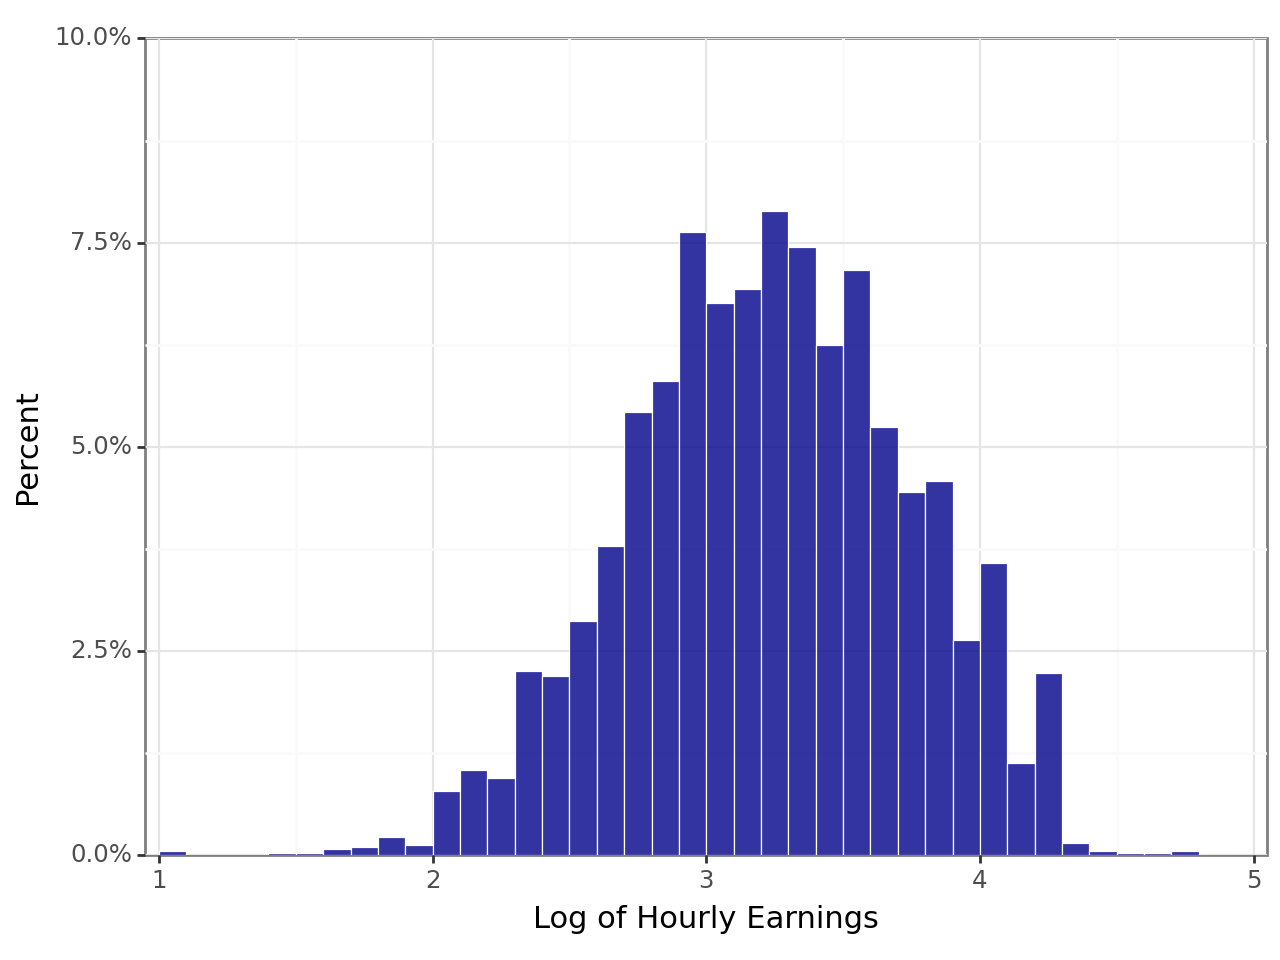

<Figure Size: (640 x 480)>

In [19]:
plot1 = (
    ggplot(data_filtered_business, aes(x="ln_earnings_per_hour", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill="darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Log of Hourly Earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(),
    )
    + theme_bw()
)

plot1


#### 2.7.2 Wages/Age

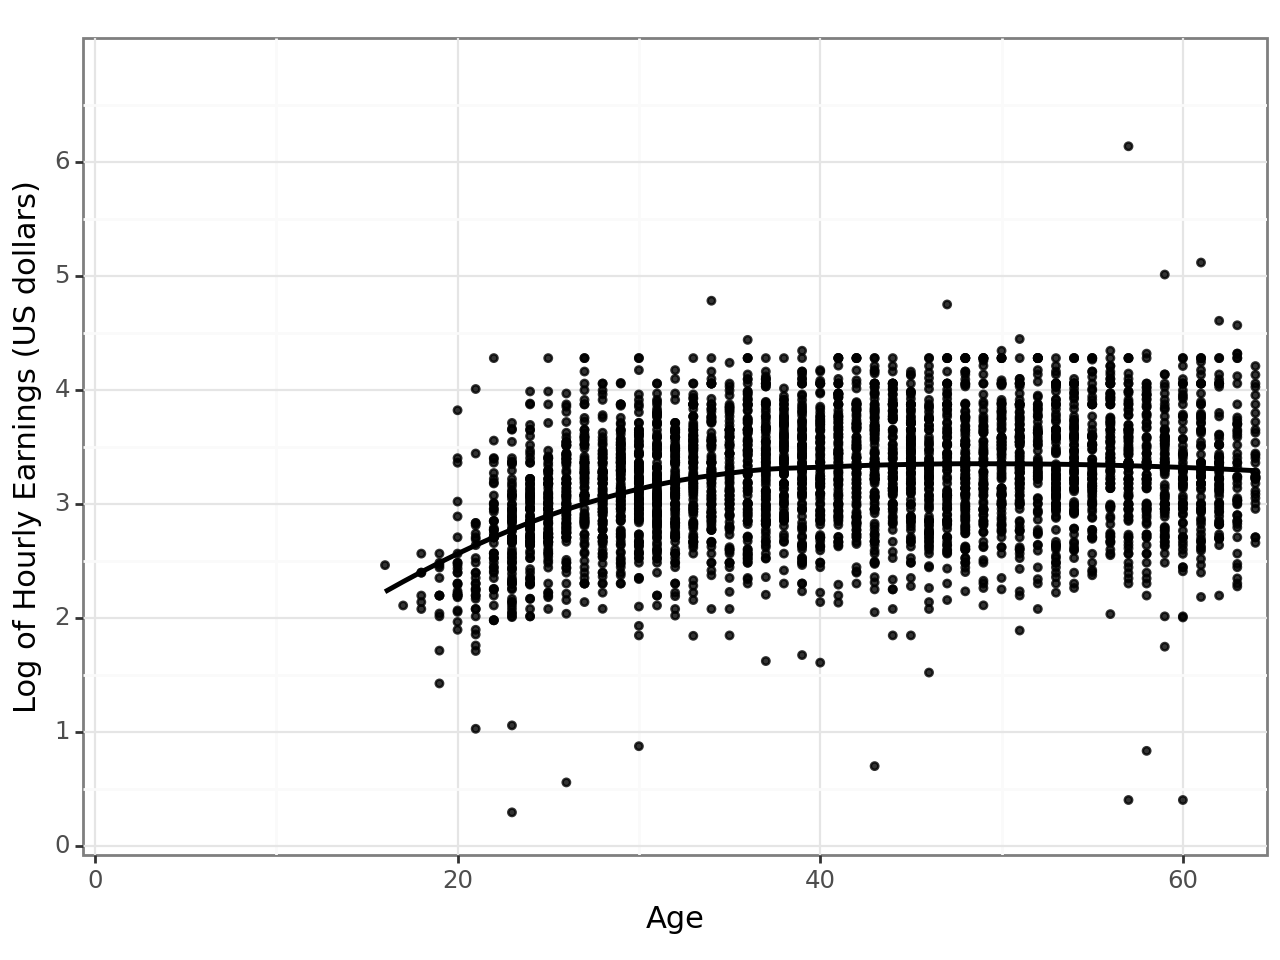

<Figure Size: (640 x 480)>

In [20]:
plot2 = (
    ggplot(data_filtered_business, aes(x="age", y="ln_earnings_per_hour"))
    + geom_point(size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", se=False, size=1, span=0.9)
    + labs(x="Age", y="Log of Hourly Earnings (US dollars)")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1))
    + scale_x_continuous(expand=(0.01, 0.01))  # Adjusted for age range
)

plot2

#### 2.7.3 Wages/Number of Childeren

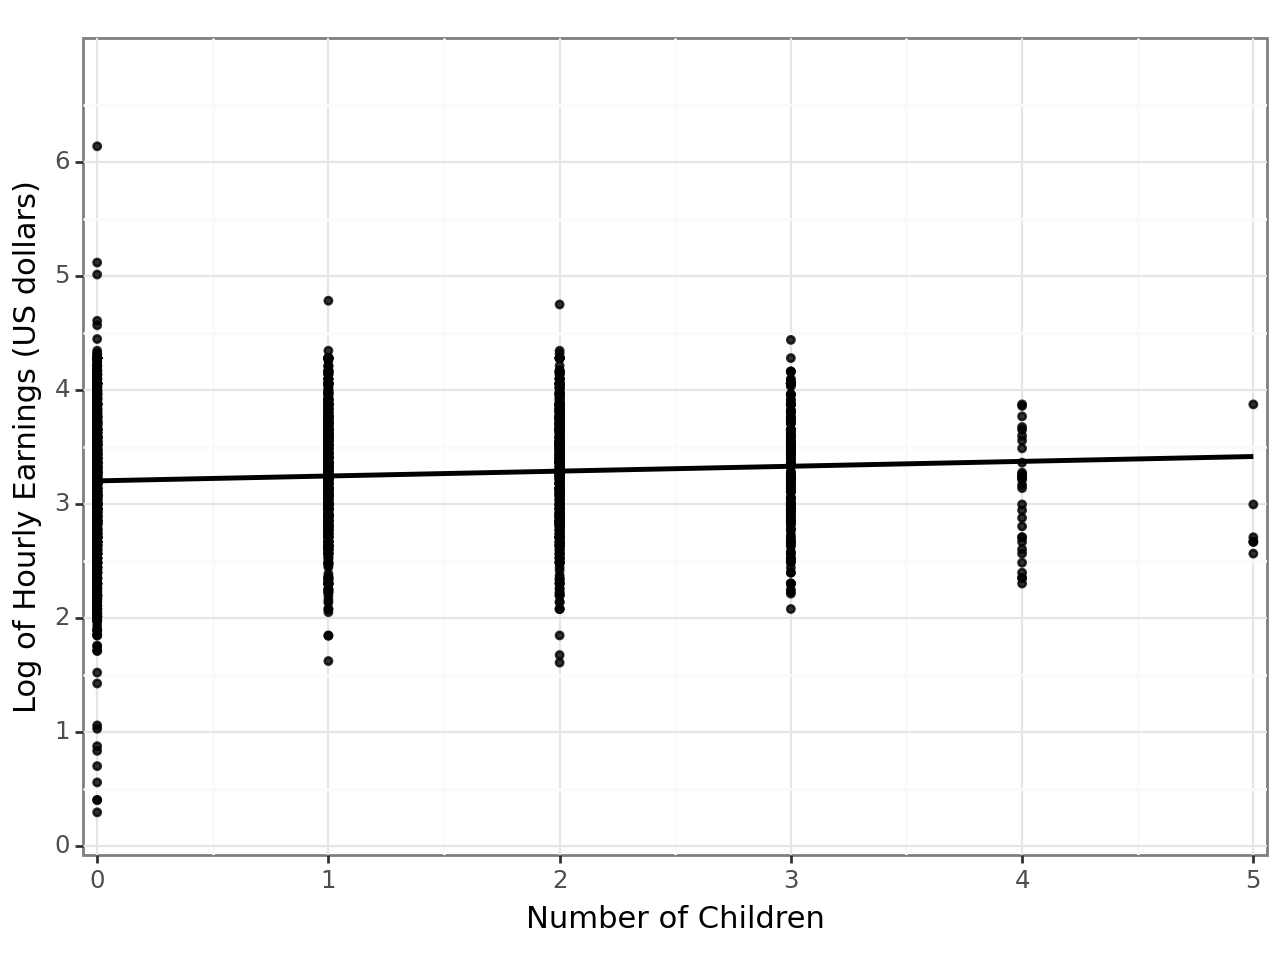

<Figure Size: (640 x 480)>

In [21]:
plot3 = (
    ggplot(data_filtered_business, aes(x="ownchild", y="ln_earnings_per_hour"))
    + geom_point(size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="lm", se=False, size=1)  # Using linear regression for smoothing
    + labs(x="Number of Children", y="Log of Hourly Earnings (US dollars)")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1))
    + scale_x_continuous(expand=(0.01, 0.01))  # Adjust the range as needed
)

plot3

#### 2.7.4 Wages/Level of Education

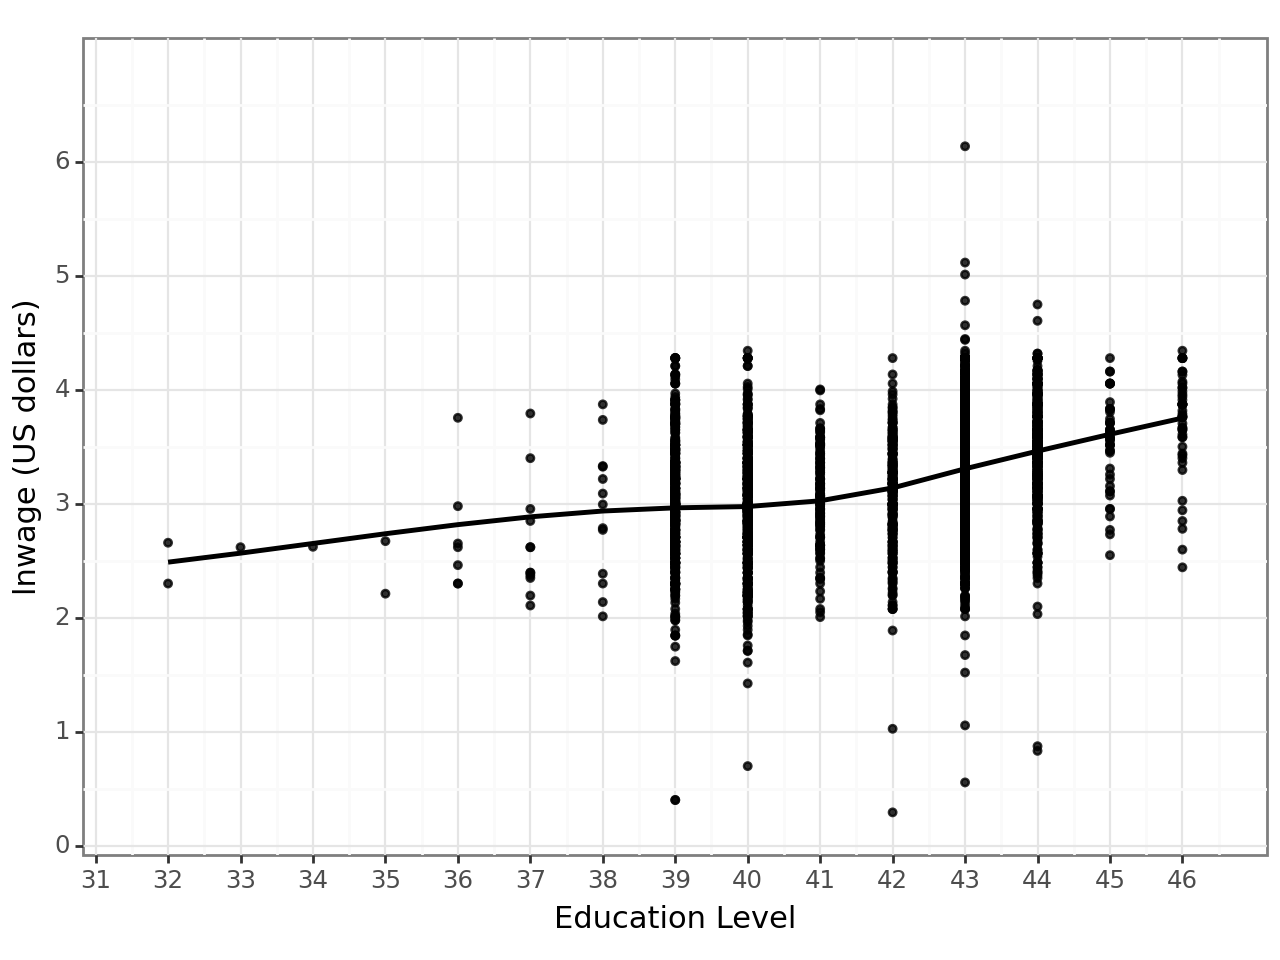

<Figure Size: (640 x 480)>

In [22]:
plot4 = (
    ggplot(data_filtered_business, aes(x="grade92", y="ln_earnings_per_hour")) 
    + geom_point(size=1, alpha=0.8, show_legend=False, na_rm=True) 
    + geom_smooth(method="loess", se=False, size=1, span=0.9) 
    + labs(x="Education Level", y="lnwage (US dollars)") 
    + theme_bw() 
    + expand_limits(x=0.01, y=0.01) 
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)) 
    + scale_x_continuous(expand=(0.01, 0.01), limits=(31, 47), breaks=np.arange(31, 47, 1))
)

plot4

## 3. Model Building

### 3.1 Model 1 - Gender

In [23]:
# Model 1: hourly wage gap for women
model1 = smf.ols(formula="ln_earnings_per_hour ~ female", data=data_filtered_business).fit(cov_type="HC0")
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ln_earnings_per_hour   R-squared:                       0.027
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     105.4
Date:                  Sun, 21 Jan 2024   Prob (F-statistic):           2.03e-24
Time:                          16:03:32   Log-Likelihood:                -2984.3
No. Observations:                  3917   AIC:                             5973.
Df Residuals:                      3915   BIC:                             5985.
Df Model:                             1                                         
Covariance Type:                    HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3303      0.013    251.200      0.000       3.304       3.356
female        -0.1741      0.017    -10.267      0.000      -0.207      -0.141
==============================================================================
Omnibus:                      171.541   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.204
Skew:                          -0.323   Prob(JB):                     1.20e-72
Kurtosis:                       4.270   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 3.2 Model 2 - Gender, Union Membership, Education Level

In [24]:
# Model 2: Hourly wage gap for women who are union members and their education levels
model2 = smf.ols(formula="ln_earnings_per_hour ~ female + union_member + MA_degree + Prof_degree + PhD_degree", data=data_filtered_business).fit(cov_type="HC0")
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ln_earnings_per_hour   R-squared:                       0.085
Model:                              OLS   Adj. R-squared:                  0.084
Method:                   Least Squares   F-statistic:                     82.35
Date:                  Sun, 21 Jan 2024   Prob (F-statistic):           1.89e-82
Time:                          16:03:32   Log-Likelihood:                -2863.9
No. Observations:                  3917   AIC:                             5740.
Df Residuals:                      3911   BIC:                             5777.
Df Model:                             5                                         
Covariance Type:                    HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.2613      0.014    233.964      0.000       3.234       3.289
female          -0.1598      0.016     -9.687      0.000      -0.192      -0.127
union_member     0.0435      0.031      1.423      0.155      -0.016       0.103
MA_degree        0.3055      0.021     14.725      0.000       0.265       0.346
Prof_degree      0.3497      0.061      5.770      0.000       0.231       0.469
PhD_degree       0.5217      0.066      7.958      0.000       0.393       0.650
==============================================================================
Omnibus:                      205.160   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.822
Skew:                          -0.315   Prob(JB):                    1.94e-106
Kurtosis:                       4.608   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 3.3 Model 3 - Gender, Age, Number of Childeren, Union Membership, Education Level

In [25]:
# Model 3: Hourly wage gap including unionship and education levels, age and childeren
model3 = smf.ols(formula="ln_earnings_per_hour ~ female + union_member + MA_degree + Prof_degree + PhD_degree + age + ownchild", data=data_filtered_business).fit(cov_type="HC0")
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ln_earnings_per_hour   R-squared:                       0.155
Model:                              OLS   Adj. R-squared:                  0.153
Method:                   Least Squares   F-statistic:                     103.7
Date:                  Sun, 21 Jan 2024   Prob (F-statistic):          1.44e-139
Time:                          16:03:32   Log-Likelihood:                -2708.1
No. Observations:                  3917   AIC:                             5432.
Df Residuals:                      3909   BIC:                             5482.
Df Model:                             7                                         
Covariance Type:                    HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7639      0.032     86.630      0.000       2.701       2.826
female          -0.1550      0.016     -9.801      0.000      -0.186      -0.124
union_member    -0.0002      0.030     -0.007      0.994      -0.059       0.059
MA_degree        0.2944      0.020     14.545      0.000       0.255       0.334
Prof_degree      0.3235      0.060      5.349      0.000       0.205       0.442
PhD_degree       0.4554      0.066      6.900      0.000       0.326       0.585
age              0.0114      0.001     16.609      0.000       0.010       0.013
ownchild         0.0454      0.008      5.696      0.000       0.030       0.061
==============================================================================
Omnibus:                      242.519   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.878
Skew:                          -0.350   Prob(JB):                    7.50e-137
Kurtosis:                       4.831   Cond. No.                         407.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

### 3.4 Model 4

In [26]:
# Model 4: Hourly wage gap including unionship and education levels, age, childeren, and origin data
model4 = smf.ols(formula="ln_earnings_per_hour ~ female + union_member + MA_degree + Prof_degree + PhD_degree + age + ownchild + Private_For_Profit + Government_Federal + Government_State + Government_Local + Native_Born_In_US + Foreign_Born_Not_US_Citizen + Foreign_Born_US_Citizen_By_Naturalization + Native_Born_Abroad_Of_US_Parents", data=data_filtered_business).fit(cov_type="HC0")
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ln_earnings_per_hour   R-squared:                       0.168
Model:                              OLS   Adj. R-squared:                  0.164
Method:                   Least Squares   F-statistic:                     55.84
Date:                  Sun, 21 Jan 2024   Prob (F-statistic):          2.88e-152
Time:                          16:03:32   Log-Likelihood:                -2678.2
No. Observations:                  3917   AIC:                             5388.
Df Residuals:                      3901   BIC:                             5489.
Df Model:                            15                                         
Covariance Type:                    HC0                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     2.6710      0.149     17.985      0.000       2.380       2.962
female                                       -0.1486      0.016     -9.392      0.000      -0.180      -0.118
union_member                                  0.0352      0.032      1.101      0.271      -0.027       0.098
MA_degree                                     0.2968      0.020     14.583      0.000       0.257       0.337
Prof_degree                                   0.3338      0.059      5.644      0.000       0.218       0.450
PhD_degree                                    0.4322      0.066      6.531      0.000       0.302       0.562
age                                           0.0113      0.001     16.418      0.000       0.010       0.013
ownchild                                      0.0441      0.008      5.572      0.000       0.029       0.060
Private_For_Profit                            0.0718      0.027      2.626      0.009       0.018       0.125
Government_Federal                            0.1941      0.037      5.194      0.000       0.121       0.267
Government_State                             -0.1114      0.042     -2.639      0.008      -0.194      -0.029
Government_Local                              0.0208      0.044      0.473      0.636      -0.066       0.107
Native_Born_In_US                             0.0320      0.143      0.223      0.823      -0.249       0.313
Foreign_Born_Not_US_Citizen                  -0.0392      0.153     -0.256      0.798      -0.339       0.260
Foreign_Born_US_Citizen_By_Naturalization     0.0687      0.147      0.467      0.640      -0.219       0.357
Native_Born_Abroad_Of_US_Parents             -0.0281      0.155     -0.181      0.856      -0.332       0.276
==============================================================================
Omnibus:                      229.315   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              588.629
Skew:                          -0.330   Prob(JB):                    1.52e-128
Kurtosis:                       4.781   Cond. No.                     1.77e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.5 Summary with Stargazer

In [27]:
# Get all the necessary models
all_star = stargazer.Stargazer([model1,model2,model3,model4])

# Reorder for better visibility
all_star.covariate_order(["female","union_member","MA_degree","Prof_degree","PhD_degree","age","ownchild","Private_For_Profit","Government_Federal","Government_State","Government_Local","Native_Born_In_US","Foreign_Born_Not_US_Citizen","Foreign_Born_US_Citizen_By_Naturalization","Native_Born_Abroad_Of_US_Parents","Intercept"])

all_star

### 3.6 Plot prediction for number of childeren

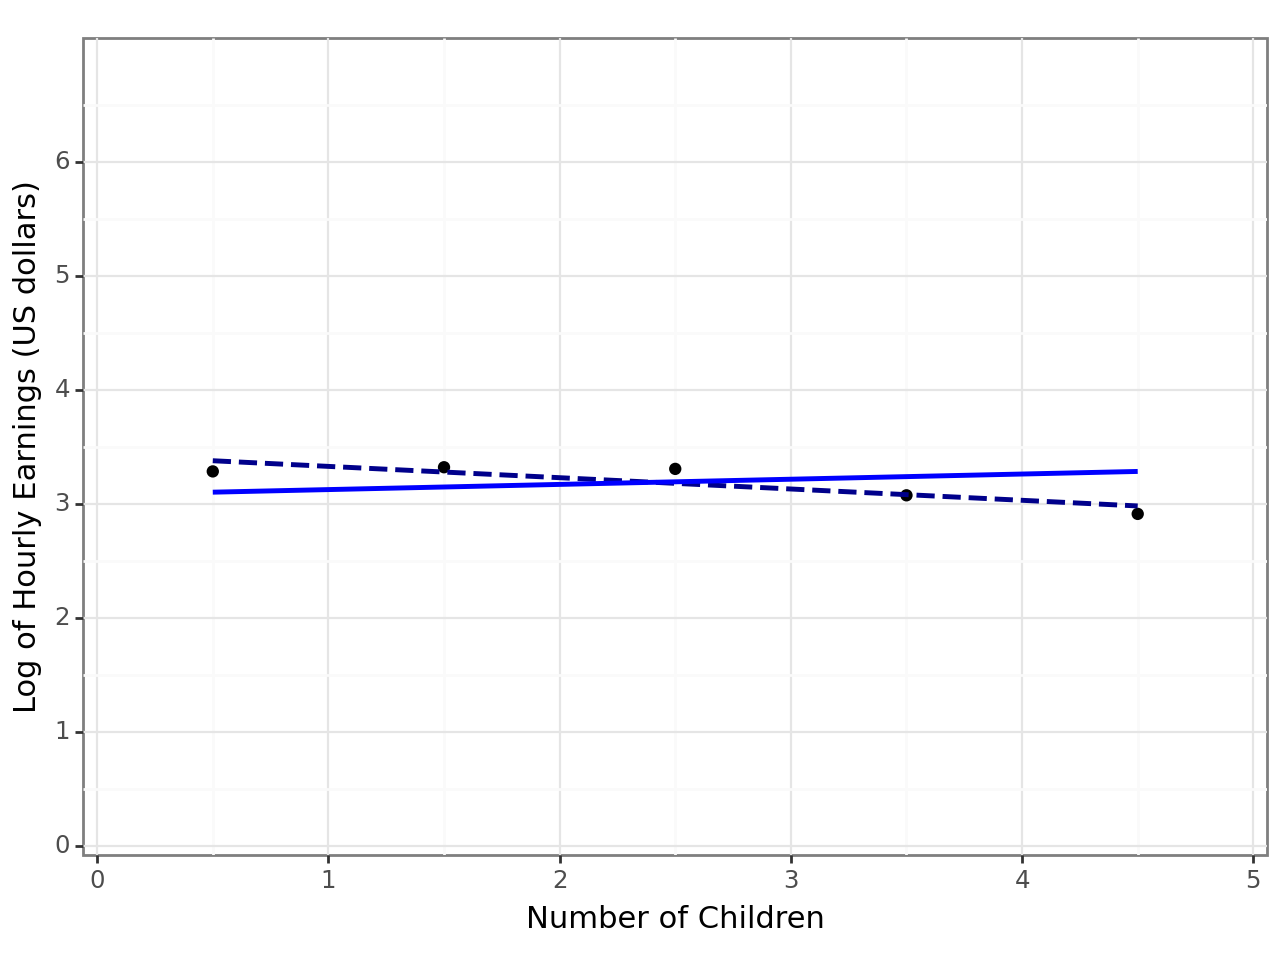

<Figure Size: (640 x 480)>

In [28]:
# Bin the 'ownchild' variable
data_filtered_business['child_bin'] = pd.cut(data_filtered_business['ownchild'], bins=np.arange(0, data_filtered_business['ownchild'].max() + 1, 1))

# Calculate the mean of 'ln_earnings_per_hour' for each child bin
child_bin_means = data_filtered_business.groupby('child_bin')['ln_earnings_per_hour'].mean().reset_index()

# Calculate the mid-point of each child bin for plotting
child_bin_means['child_bin_mid'] = child_bin_means['child_bin'].apply(lambda x: x.mid).astype(float)

# Create a DataFrame for prediction with the necessary columns
predict_df = pd.DataFrame({
    'female': data_filtered_business['female'].mode()[0],  # Mode for categorical
    'union_member': data_filtered_business['union_member'].mode()[0],  # Mode for categorical
    'MA_degree': data_filtered_business['MA_degree'].mode()[0],  # Mode for categorical
    'Prof_degree': data_filtered_business['Prof_degree'].mode()[0],  # Mode for categorical
    'PhD_degree': data_filtered_business['PhD_degree'].mode()[0],  # Mode for categorical
    'age': data_filtered_business['age'].mean(),  # Mean for continuous
    'ownchild': child_bin_means['child_bin_mid']  # Binned values
})

# Repeat this value filling for all rows in predict_df
predict_df = predict_df.assign(**{col: predict_df[col].iloc[0] for col in predict_df.columns if col != 'ownchild'})

# Use 'predict_df' to get predictions
child_bin_means['predicted_ln_earnings'] = model3.predict(predict_df)


plot5 = (ggplot(child_bin_means, aes(x='child_bin_mid', y='ln_earnings_per_hour')) 
        + geom_point() 
        + geom_smooth(aes(x='child_bin_mid', y='ln_earnings_per_hour'), method='lm', colour='darkblue', linetype='dashed', se=False, size=1)
        + geom_line(aes(x='child_bin_mid', y='predicted_ln_earnings'), colour="blue", size=1)
        + labs(x='Number of Children', y='Log of Hourly Earnings (US dollars)')
        + theme_bw()
        + scale_x_continuous(expand=(0.01, 0.01), limits=(0, data_filtered_business['ownchild'].max()), breaks=np.arange(0, data_filtered_business['ownchild'].max() + 1, 1))
        + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=np.arange(0, 7, 1)))

plot5


## 4. Model Evaluation

### 4.1 BIC

In [29]:
# Calculate BIC for each model
bic = [round(x.bic, 2) for x in [model1,model2,model3,model4]]

# Print the BIC values
for i, bic_value in enumerate(bic):
    print(f"Model {i+1} BIC: {bic_value}")


Model 1 BIC: 5985.23
Model 2 BIC: 5777.35
Model 3 BIC: 5482.38
Model 4 BIC: 5488.74


### 4.2 RMSE - Full sample

In [30]:
# Calculate RMSE for Model 1 - Gender
y_pred_model1 = model1.predict(data_filtered_business)
rmse_model1 = rmse(data_filtered_business['ln_earnings_per_hour'], y_pred_model1)

# Calculate RMSE for Model 2 - Gender, Union Membership, Education Level
y_pred_model2 = model2.predict(data_filtered_business)
rmse_model2 = rmse(data_filtered_business['ln_earnings_per_hour'], y_pred_model2)

# Calculate RMSE for Model 3 - Gender, Age, Number of Children, Union Membership, Education Level
y_pred_model3 = model3.predict(data_filtered_business)
rmse_model3 = rmse(data_filtered_business['ln_earnings_per_hour'], y_pred_model3)

# Calculate RMSE for Model 4
y_pred_model4 = model4.predict(data_filtered_business)
rmse_model4 = rmse(data_filtered_business['ln_earnings_per_hour'], y_pred_model4)

# Print RMSE values
print(f"RMSE for Model 1: {rmse_model1}")
print(f"RMSE for Model 2: {rmse_model2}")
print(f"RMSE for Model 3: {rmse_model3}")
print(f"RMSE for Model 4: {rmse_model4}")

RMSE for Model 1: 0.5183815628994818
RMSE for Model 2: 0.502679239506158
RMSE for Model 3: 0.4830823173029549
RMSE for Model 4: 0.4794074609451212


### 4.3 RMSE - cross validated

In [31]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [32]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [33]:
cv1 = cv_reg("ln_earnings_per_hour~female", data_filtered_business, k, "HC0")
cv2 = cv_reg("ln_earnings_per_hour~female + union_member + MA_degree + Prof_degree + PhD_degree", data_filtered_business, k, "HC0")
cv3 = cv_reg("ln_earnings_per_hour~female + union_member + MA_degree + Prof_degree + PhD_degree + age + ownchild", data_filtered_business, k, "HC0")
cv4 = cv_reg("ln_earnings_per_hour~female + union_member + MA_degree + Prof_degree + PhD_degree + age + ownchild + Private_For_Profit + Government_Federal + Government_State + Government_Local + Native_Born_In_US + Foreign_Born_Not_US_Citizen + Foreign_Born_US_Citizen_By_Naturalization + Native_Born_Abroad_Of_US_Parents", data_filtered_business, k, "HC0")

cv_list = [cv1, cv2, cv3, cv4]

In [34]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,0.510675,0.494410,0.477665,0.475206
Fold2,0.519754,0.504476,0.485075,0.480029
Fold3,0.523821,0.507290,0.485661,0.481275
Fold4,0.519091,0.504133,0.483260,0.480011
Average,0.518335,0.502577,0.482915,0.479130


## 5. Analysis of Model Performance

### 5.1 Checking model performance

#### 5.1.1 Creating new record

In [35]:
# Define a new observation
new_observation = pd.DataFrame({
    'female': [1],
    'union_member': [1],
    'MA_degree': [1],
    'Prof_degree': [0],
    'PhD_degree': [0],
    'age': [42],
    'ownchild': [1],
    'Private_For_Profit': [0],
    'Government_Federal': [0],
    'Government_State': [0],
    'Government_Local': [0],
    'Native_Born_In_US': [1],
    'Foreign_Born_Not_US_Citizen': [0],
    'Foreign_Born_US_Citizen_By_Naturalization': [0],
    'Native_Born_Abroad_Of_US_Parents': [0]
})

new_observation


,female,union_member,MA_degree,Prof_degree,PhD_degree,age,ownchild,Private_For_Profit,Government_Federal,Government_State,Government_Local,Native_Born_In_US,Foreign_Born_Not_US_Citizen,Foreign_Born_US_Citizen_By_Naturalization,Native_Born_Abroad_Of_US_Parents
0,1,1,1,0,0,42,1,0,0,0,0,1,0,0,0


#### 5.1.2 Checking 95% CI prediction

In [36]:
# Get predictions from model1
p1_95 = model1.get_prediction(new_observation).summary_frame()

p1_95

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.15615,0.010579,3.135415,3.176884,2.139669,4.17263


In [37]:
# Get predictions from model3
p3_95 = model3.get_prediction(new_observation).summary_frame()

p3_95

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.425596,0.034067,3.358827,3.492366,2.475455,4.375738


In [38]:
# Creating a DataFrame with the predictions and prediction intervals
predictions_summary_95 = pd.DataFrame({
    " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
    "Model1": p1_95[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    "Model3": p3_95[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
}).set_index(" ")

predictions_summary_95

,Model1,Model3
,,
Predicted,3.156150,3.425596
PI_low(95%),2.139669,2.475455
PI_high(95%),4.172630,4.375738


#### 5.1.3 Checking 80% CI prediction

In [39]:
# Get predictions from model1
p1_80 = model1.get_prediction(new_observation).summary_frame(alpha=0.2)

p1_80

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.15615,0.010579,3.142592,3.169707,2.491509,3.82079


In [40]:
# Get predictions from model3
p3_80 = model3.get_prediction(new_observation).summary_frame(alpha=0.2)

p3_80

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.425596,0.034067,3.381938,3.469255,2.804332,4.04686


In [41]:
# Creating a DataFrame with the predictions and prediction intervals
predictions_summary_80 = pd.DataFrame({
    " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
    "Model1": p1_80[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    "Model3": p3_80[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
}).set_index(" ")

predictions_summary_80

,Model1,Model3
,,
Predicted,3.156150,3.425596
PI_low(80%),2.491509,2.804332
PI_high(80%),3.820790,4.046860
